In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo
import pandas as pd

In [2]:
### Markowitz portfolio optimization
class EfficientFrontier:
    """
    Returns the optimal portfolio weights and the corresponding Sharpe ratio.
    Reference: https://ocw.mit.edu/courses/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/resources/mit18_s096f13_lecnote14/
    Returns: Must have at least 2 assets each with at least 2 returns listed.
    Return period: >= 2, 12 for monthly, 52 for weekly, 252 for yearly.
    """
    def __init__(self, tickers: list, returns: list, return_period: int):
        self.TICKERS = tickers
        self.UNIFORM_WEIGHTS = np.ones(len(returns)) / len(returns)
        self.RETURNS = np.asarray(returns).copy()
        self.FREQUENCY = return_period
        self.COV = np.cov(self.RETURNS)
    
    def _neg_sharpe_ratio(self, weights: list, risk_free_rate: float = 0.0):
        """
        Returns the Sharpe ratio of the portfolio.
        """
        expected_return = np.sum(np.dot(weights, self.RETURNS))*self.FREQUENCY
        standard_deviation = np.sqrt(np.dot(weights, np.dot(self.COV, weights)))*np.sqrt(self.FREQUENCY)
        return - ((expected_return - risk_free_rate) / standard_deviation)
    
    def _mean(self, weights: list):
        """
        Returns the expected return of the portfolio.
        """
        return np.sum(np.dot(weights, self.RETURNS))*self.FREQUENCY
    
    def _variance(self, weights: list):
        """
        Returns the variance of the portfolio.
        """
        return np.dot(weights.T, np.dot(self.COV, weights))

    def _sd(self, weights: list):
        """
        Returns the standard deviation of the portfolio.
        """
        return np.sqrt(np.dot(weights, np.dot(self.COV, weights)))*np.sqrt(self.FREQUENCY)

    # Return Maximization
    def max_sharpe(self, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Returns the optimal portfolio weights and the corresponding Sharpe ratio.
        Use the negative Sharpe ratio as the objective function to be minimized.
        """
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        args = (risk_free_rate)
        # minimize the negative Sharpe ratio
        result = spo.minimize(self._neg_sharpe_ratio, init_weights, method=method, bounds=bounds, constraints=constraints, args=args)
        # status, weights, Sharpe ratio, mean, variance, stdev
        return result.success, result.x, -self._neg_sharpe_ratio(result.x, risk_free_rate), self._mean(result.x), self._variance(result.x), self._sd(result.x)
        
    # Risk Minimization
    def min_variance(self, weight_constraint: tuple = (0,1), risk_free_rate: float = 0.0):
        """
        Returns the optimal portfolio weights and the corresponding variance.
        Use the variance as the objective function to be minimized.
        """
        # minimize the variance
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        # , 'type': 'eq', 'fun': lambda x: np.dot(x, self.RETURNS) - target_return
        constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        result = spo.minimize(self._variance, init_weights, method=method, bounds=bounds, constraints=constraints)
        # status, weights, Sharpe, mean:return, variance, stdev
        return result.success, result.x, -self._neg_sharpe_ratio(result.x, risk_free_rate), self._mean(result.x), self._variance(result.x), self._sd(result.x)

    # Optimize a portfolio given a target return or a target variance
    def optimize(self, target_return: float = None, target_variance: float = None, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Returns the optimal portfolio weights and the corresponding Sharpe ratio.
        Use the negative Sharpe ratio as the objective function to be minimized.
        """
        # minimize the negative Sharpe ratio
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        if target_return is not None:
            constraints=({'type': 'eq', 'fun': lambda x: self._mean(x) - target_return}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            args = (risk_free_rate)
            result = spo.minimize(self._neg_sharpe_ratio, init_weights, method=method, bounds=bounds, constraints=constraints, args=args)
        elif target_variance is not None:
            constraints=({'type': 'eq', 'fun': lambda x: self._variance(x) - target_variance}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            result = spo.minimize(self._variance, init_weights, method=method, bounds=bounds, constraints=constraints)
        else:
            raise ValueError("Must provide either a target return or a target variance, but not both.")
        
        # status, weights, Sharpe ratio, mean, variance, std
        return result.success, result.x, -self._neg_sharpe_ratio(result.x, risk_free_rate), self._mean(result.x), self._variance(result.x), self._sd(result.x)
    
    # Create a summary table of optimal portfolios, weights, Sharpe ratios, means, and variances
    def summary(self, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Returns a summary table of optimal portfolios, weights, Sharpe ratios, means, and variances.
        """
        # opt portfolios
        min_variance = self.min_variance(weight_constraint, risk_free_rate)
        max_sharpe = self.max_sharpe(risk_free_rate, weight_constraint)
        # summary table
        max_sharpe_df = pd.DataFrame(columns=['Tickers', 'Weights'])
        min_var_df = pd.DataFrame(columns=['Tickers', 'Weights'])
        summary_df = pd.DataFrame(columns=['Portfolio', 'Weights', 'Sharpe Ratio', 'Return', 'Variance', 'Standard Deviation'])
        # max sharpe
        max_sharpe_df['Tickers'] = self.TICKERS
        max_sharpe_df['Weights'] = max_sharpe[1].round(4)
        max_sharpe_df = max_sharpe_df.set_index('Tickers')
        print("Max Sharpe:")
        print(max_sharpe_df)
        # min variance
        min_var_df['Tickers'] = self.TICKERS
        min_var_df['Weights'] = min_variance[1].round(4)
        min_var_df = min_var_df.set_index('Tickers')
        print("Min Variance:")
        print(min_var_df)
        # summary
        summary_df['Portfolio'] = ['Max Sharpe', 'Min Variance']
        summary_df['Weights'] = [dict(zip(self.TICKERS, max_sharpe[1].round(4))),dict(zip(self.TICKERS, min_variance[1].round(4)))]
        summary_df['Sharpe Ratio'] = [max_sharpe[2].round(4), min_variance[2].round(4)]
        summary_df['Return'] = [max_sharpe[3].round(4), min_variance[3].round(4)]
        summary_df['Variance'] = [max_sharpe[4].round(4), min_variance[4].round(4)]
        summary_df['Standard Deviation'] = [max_sharpe[5].round(4), min_variance[5].round(4)]
        summary_df = summary_df.set_index('Portfolio')
        print("Summary:")
        print(summary_df)
        return summary_df, max_sharpe_df, min_var_df



    # Plot the efficient frontier
    def efficient_frontier(self, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Plots the efficient frontier.
        Iterates through optimal portfolios from min_variance to max_sharpe.
        """
        returns = []
        stds = []
        min_var_x = self.min_variance(weight_constraint, risk_free_rate)[1]
        max_sharpe_x = self.max_sharpe(risk_free_rate, weight_constraint)[1]
        target_returns = np.linspace(self._mean(min_var_x) - self._sd(min_var_x), self._mean(max_sharpe_x), 25)
        for target_return in target_returns:
            opt = self.optimize(target_return=target_return, risk_free_rate=risk_free_rate, weight_constraint=weight_constraint)
            # append the means and stds as a percentage to 2 decimal places
            returns.append(opt[3])
            stds.append(opt[5])
        plt.figure(figsize=(12,8))
        plt.scatter(stds, returns, marker='o')
        plt.grid(True)
        plt.xlabel('Expected Volatility (\u03C3)')
        plt.ylabel('Expected Return (\u03BC)')
        plt.title('Efficient Frontier')
        # plot efficient frontier
        plt.plot(stds, returns,  color='black')
        # plot the best possible CAL as y= risk-free rate + (sharpe ratio * standard deviation of portfolio)
        plt.plot(np.linspace(min(stds)-np.std(stds), max(stds)+np.std(stds)), risk_free_rate + (self.max_sharpe(risk_free_rate, weight_constraint)[2] * np.linspace(min(stds) - np.std(stds), max(stds)+np.std(stds))), color='r', label='Capital Allocation Line (CAL)')
        # plot the min variance as a vertical dashed black line
        plt.axvline(x=self._sd(self.min_variance(weight_constraint, risk_free_rate)[1]), color='g', linestyle='--', label='Min Variance')
        # plot the max sharpe ratio as a horizontal dashed black line
        plt.axhline(y=self._mean(self.max_sharpe(risk_free_rate, weight_constraint)[1]), color='r', linestyle='--', label='Max Sharpe')
        # shift the plot to center on the efficient frontier
        plt.xlim([min(stds) - np.std(stds), max(stds) + np.std(stds)])
        plt.ylim([min(returns)-np.std(returns), max(returns)+np.std(returns)])
         # Plot and label the max Sharpe portfolio and the min variance portfolio and show their values
        plt.scatter(self._sd(self.max_sharpe(risk_free_rate, weight_constraint)[1]), self._mean(self.max_sharpe(risk_free_rate, weight_constraint)[1]),  marker='o', s=150, color='r',  label='Max Sharpe')
        plt.scatter(self._sd(self.min_variance(weight_constraint, risk_free_rate)[1]), self._mean(self.min_variance(weight_constraint, risk_free_rate)[1]),  marker='o', s=150, color='g', label='Min Variance')
        
        plt.legend()
        plt.show()



        


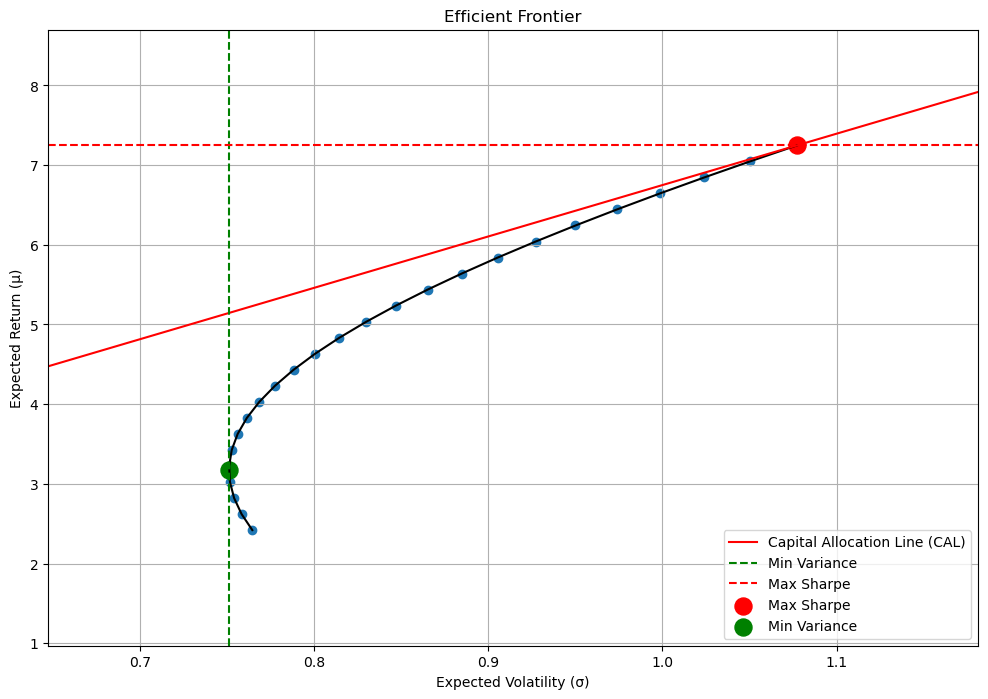

In [3]:
# test max sharpe
tickers = ['AAPL', 'GOOG', 'SPY']
returns =[[.8231, .3465, -.2651, .9075], [.3103, .6517, -.3867, .8391], [-.2484, .3446, -.2054, .5501] ]
markowitz= EfficientFrontier(tickers, returns, 4)
# markowitz.summary()

# test efficient frontier
markowitz.efficient_frontier(risk_free_rate=0.3)

